<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-Data" data-toc-modified-id="Get-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get Data</a></span><ul class="toc-item"><li><span><a href="#Data-Checks" data-toc-modified-id="Data-Checks-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Checks</a></span></li></ul></li><li><span><a href="#Clean-Data" data-toc-modified-id="Clean-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Clean Data</a></span><ul class="toc-item"><li><span><a href="#Clean-source-column" data-toc-modified-id="Clean-source-column-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Clean source column</a></span></li><li><span><a href="#Clean-Age-Columns" data-toc-modified-id="Clean-Age-Columns-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Clean Age Columns</a></span></li></ul></li><li><span><a href="#Clean-columns" data-toc-modified-id="Clean-columns-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clean columns</a></span><ul class="toc-item"><li><span><a href="#Drop-unused-columns" data-toc-modified-id="Drop-unused-columns-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Drop unused columns</a></span></li><li><span><a href="#Fix-column-types-and-names" data-toc-modified-id="Fix-column-types-and-names-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Fix column types and names</a></span></li></ul></li><li><span><a href="#Add-trial_no" data-toc-modified-id="Add-trial_no-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Add trial_no</a></span><ul class="toc-item"><li><span><a href="#Save-data" data-toc-modified-id="Save-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Save data</a></span></li></ul></li><li><span><a href="#Descriptive-Stats" data-toc-modified-id="Descriptive-Stats-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Descriptive Stats</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Meta-Info" data-toc-modified-id="Meta-Info-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>Meta Info</a></span></li><li><span><a href="#Sources" data-toc-modified-id="Sources-5.0.2"><span class="toc-item-num">5.0.2&nbsp;&nbsp;</span>Sources</a></span></li></ul></li><li><span><a href="#Desc-Stat-Tables" data-toc-modified-id="Desc-Stat-Tables-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Desc Stat Tables</a></span></li><li><span><a href="#Desc-Stat-Plots" data-toc-modified-id="Desc-Stat-Plots-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Desc Stat Plots</a></span></li></ul></li><li><span><a href="#Race-conditions/trials" data-toc-modified-id="Race-conditions/trials-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Race conditions/trials</a></span></li></ul></div>

# Get Data

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np 
import os
import ast


def query_database(client, query):
    query_job = client.query(query)
    df = query_job.to_dataframe()
    return df 

def fetch_experiment_data():
    print("Fetching data")
    key_path = f"../../secrets/google_creds.json"
    credentials = service_account.Credentials.from_service_account_file(key_path,
                                                                        scopes=[
                                                                            "https://www.googleapis.com/auth/cloud-platform"], )
    client = bigquery.Client(credentials=credentials, project=credentials.project_id)
    first_query = """SELECT * FROM
    `net_expr.trials` AS t
    INNER JOIN `net_expr.person` as p
    ON t.participant_id = p.participant_id
    WHERE
    p.is_test is FALSE AND
    p.participant_id != 'seed' AND
    world <= 6 AND
    t.response_date <= '2023-07-27T16:13:15'
    """
    df = query_database(client, first_query)
    return df
        

df = fetch_experiment_data()
df['init_array'] = df['init_array'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df['exclude_from_analysis'] = 0

Fetching data


In [2]:
# import pandas as pd
# import json

# # Define correct data types excluding datetime
# dtype_dict = {
#     'response_id': 'object',
#     'participant_id': 'object',
#     'response_text': 'object',
#     'condition': 'object',
#     'condition_order': 'Int64',
#     'item': 'object',
#     'world': 'Int64',
#     'init_array': 'object',  # This will be handled post-read
#     'ranked_array': 'object',  # This will be handled post-read
#     'is_test': 'boolean',
#     'duration': 'float64',
#     'is_troll': 'boolean',
#     'is_profane': 'boolean',
#     'is_prolific': 'boolean',
#     'participant_id_1': 'object',
#     'creativity_human': 'Int64',
#     'ai_feeling': 'object',
#     'country': 'object',
#     'age': 'Int64',
#     'is_test_1': 'boolean',
#     'referer': 'object',
#     'request_args': 'object',
#     'is_prolific_1': 'boolean',
#     'prolific_id': 'object',
#     'gender': 'object',
#     'gender_describe': 'object',
#     'exclude_from_analysis': 'int64'
# }

# # Columns to parse as dates
# parse_dates = ['response_date', 'dt']

# # Read the CSV with specified data types and parse dates
# df2 = pd.read_csv("raw.csv", dtype=dtype_dict, parse_dates=parse_dates)

# # Normalize datetime precision to 'us' (microseconds)
# df2['response_date'] = df2['response_date'].values.astype('datetime64[us]')
# df2['dt'] = df2['dt'].values.astype('datetime64[us]')

# # Convert 'creativity_ai' to float if it's stored as object
# df2['creativity_ai'] = df2['creativity_ai'].astype('object')

# # Post-processing for any columns that need special handling (like JSON parsing)
# df2['init_array'] = df2['init_array'].apply(lambda x: eval(x) if isinstance(x, str) else x)
# df2['ranked_array'] = df2['ranked_array'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# # Optionally, verify data types and data
# print(df2.dtypes)  # Check if the data types are now correctly aligned

# # Function to check if DataFrames are identical
# def check_dataframes_identical(df1, df2):
#     if not df1.dtypes.equals(df2.dtypes):
#         print("Data types do not match:")
#         print(df1.dtypes.compare(df2.dtypes))
#         return False
#     if not df1.equals(df2):
#         print("DataFrames values do not match.")
#         return False
#     print("DataFrames are identical.")
#     return True

# identical = check_dataframes_identical(df, df2)


# Filter data

## Filter out er_ids

In [3]:
er_ids = ['dbe96241-4d64-4ae6-bb6d-15e5e45b0760', 'e6fdd18f-de53-4159-965a-656aa75ba88d']
df.loc[df['response_id'].isin(er_ids), 'exclude_from_analysis'] = 1
print(f"Flagging {len(er_ids)} responses shown in error".format(er_ids))

Flagging 2 responses shown in error


## Filter out false positive profanity

In [4]:
df2 = df.copy()
profane_df2 = df2[df2['is_profane'] == True]
for index, x in profane_df2.iterrows():
    pass
    #print(x['response_id'], x['response_text'])
fp = ['2e834786-dbbb-422e-975c-bb35d4418fa4', 
      '23b9ec2f-4a71-46cc-bd49-ec7de18ed184', 
      'c376d9e1-3d51-486a-a914-4e5c8a2a6453',
      '9ea1c436-1d8a-4b8f-b7b4-74729c3997d6',
      '7489e80a-65b9-4d14-b260-67908c35b4b4',
      'cf5c2549-6c72-4532-8355-9de800655df6',
      'a44e3014-b960-409a-85d5-b91e195bc6da',
      '4582d0a8-d5e1-4eed-bc40-5552eaf1a790',
      'c961cc7c-6d6e-44fd-86fc-93bc9f213854',
      'd6756b75-e0ed-4f56-bead-ab9df2ab5c12']
tp = [x for x in profane_df2['response_id'] if x not in fp]
assert len(tp) + len(fp) == len(profane_df2), "TP + FP don't add up"
print(f"There were {len(profane_df2)} ideas labled as profane. {len(fp)} were false positives. We will not analyze the true positives (n={len(tp)}), resulting in {len(df) -( df['exclude_from_analysis'].sum() + len(tp))} responses.")

# Now change profane field for the false positives in a new column 
df['is_profane_clean'] = df['is_profane']  
df.loc[df['response_id'].isin(fp), 'is_profane_clean'] = False
df.loc[df['response_id'].isin(tp), 'exclude_from_analysis'] = 1
assert np.sum(df['is_profane_clean']) == len(tp), "Mismatch --> Recheck labels!"

There were 46 ideas labled as profane. 10 were false positives. We will not analyze the true positives (n=36), resulting in 3414 responses.


## But before proceeding, let's make sure no correlation between conditions and profanity.

In [5]:
from scipy.stats import chi2_contingency

def chi_square_test(dv, iv, df):
    response_sum = np.sum(1*df[dv])
    response_mean = np.round(np.mean(1*df[dv])*100,2)
    cross_tab = pd.crosstab(df[dv], df[iv])
    chi2_test = chi2_contingency(cross_tab)
    chi2_stat = chi2_test[0]
    p_value = chi2_test[1]
    dof = chi2_test[2]
    # Format the string for LaTeX with the chi-square symbol
    latex_string = "{} (n={}; {}\% of sample) did not differ by {} ($\chi^2$({}) = {:.2f}, p = {:.2f})".format(dv.replace("_", ""), response_sum, response_mean, iv.replace("_", ""),dof, chi2_stat, p_value)
    print(latex_string)
    return latex_string
# Testing the function

df['item_condition'] = df['item'] + df['condition']

for dv in ['is_profane', 'is_profane_clean', 'exclude_from_analysis']:
    for iv in ['item', 'condition', 'item_condition']:
        print(f"{dv} by {iv}")
        chi_square_test(dv, iv, df)
        print()

<>:12: SyntaxWarning: invalid escape sequence '\%'
<>:12: SyntaxWarning: invalid escape sequence '\%'
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_34236/4279137026.py:12: SyntaxWarning: invalid escape sequence '\%'
  latex_string = "{} (n={}; {}\% of sample) did not differ by {} ($\chi^2$({}) = {:.2f}, p = {:.2f})".format(dv.replace("_", ""), response_sum, response_mean, iv.replace("_", ""),dof, chi2_stat, p_value)


is_profane by item
isprofane (n=46; 1.33\% of sample) did not differ by item ($\chi^2$(4) = 3.66, p = 0.45)

is_profane by condition
isprofane (n=46; 1.33\% of sample) did not differ by condition ($\chi^2$(4) = 6.06, p = 0.19)

is_profane by item_condition
isprofane (n=46; 1.33\% of sample) did not differ by itemcondition ($\chi^2$(24) = 26.85, p = 0.31)

is_profane_clean by item
isprofaneclean (n=36; 1.04\% of sample) did not differ by item ($\chi^2$(4) = 4.51, p = 0.34)

is_profane_clean by condition
isprofaneclean (n=36; 1.04\% of sample) did not differ by condition ($\chi^2$(4) = 2.92, p = 0.57)

is_profane_clean by item_condition
isprofaneclean (n=36; 1.04\% of sample) did not differ by itemcondition ($\chi^2$(24) = 30.21, p = 0.18)

exclude_from_analysis by item
excludefromanalysis (n=38; 1.1\% of sample) did not differ by item ($\chi^2$(4) = 5.10, p = 0.28)

exclude_from_analysis by condition
excludefromanalysis (n=38; 1.1\% of sample) did not differ by condition ($\chi^2$(4) = 

# Ideas 

## Add new column that removes excluded 


In [6]:
import re
excluded = set(df.query("exclude_from_analysis==1")['response_id'].tolist())

def remove_excluded(rids):
    rids = [x for x in rids if x not in excluded]
    return rids

df['init_array'] = df['init_array'].apply(lambda ids: [re.sub(r'_world\d+$', '', id) for id in ids])
df['init_array_minus_excluded'] = df['init_array'].apply(lambda x: remove_excluded(x))
df['ranked_array_minus_excluded'] = df['ranked_array'].apply(lambda x: remove_excluded(x))

## Add 6 new columns that have the text of each example id

For each row we add columns like:
- idea1_txt: Text of 1st idea in init_array
- (...)
- idea6_text: Text of 6th idea in init_array

I create another set of columns if somebody wants the data in a convienent format where the excluded ideas are ALSO excluded from the example set
- idea_minus_excluded1_txt: Text of 1st idea in init_array if not `exclude_from_analysis==1` else np.NaN
- (...)
- idea_minus_excluded6_txt: Text of 6th idea in init_array if not `exclude_from_analysis==1` else np.NaN

However, for our analysis the excluded ideas -- meaning excluded at a row level -- are not excluded when computing diversity metrics. After all, if a participant saw an idea then they saw an idea, whether or not it *should* have been excluded.

In [7]:
excluded_txt = df.query("exclude_from_analysis==1")['response_text'].tolist()
ai_seeds_df = pd.read_csv("../../data/ai_responses.csv")
human_seeds_df = pd.read_csv("../../data/seed_human_responses.csv")

def get_response_text(response_id):
    if response_id.startswith('ai_seed'):
        return ai_seeds_df.loc[ai_seeds_df['response_id'] == response_id, 'response'].values[0]
    elif response_id.startswith('human_seed'):
        return human_seeds_df.loc[human_seeds_df['response_id'] == response_id, 'response'].values[0]
    else:
        return df.loc[df['response_id'] == response_id, 'response_text'].values[0]

for i in range(1, 7):
    df['idea{}_txt'.format(i)] = ''
    df['idea_minus_excluded{}_txt'.format(i)] = ''

# Populate the new columns with the response texts
for index, row in df.iterrows():
    for i in range(min(6, len(row['init_array']))):
        matched_text = get_response_text(row['init_array'][i])
        df.loc[index, 'idea{}_txt'.format(i+1)] = matched_text
        df.loc[index, 'idea_minus_excluded{}_txt'.format(i+1)] = matched_text if matched_text not in excluded_txt else np.NaN
        
print(len(df.query("exclude_from_analysis==0")))
    

3414


## Make sure seeds didn't differ by condition

In [8]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
seed_anova = ols('target ~ condition + aut_item + condition*aut_item', data=human_seeds_df).fit()
table = sm.stats.anova_lm(seed_anova, typ=3)
print(table)

                       sum_sq    df          F    PR(>F)
Intercept           20.702500   1.0  23.196412  0.000009
condition            4.031667   4.0   1.129335  0.350496
aut_item             4.277000   4.0   1.198056  0.320163
condition:aut_item  14.848444  16.0   1.039822  0.429153
Residual            58.011667  65.0        NaN       NaN


## Data Checks

In [9]:
def verify_rid_unique():
    print("TEST: Does every response id occur only once?")
    unique_rds = len(df['response_id'].unique())
    all_rids = len(df['response_id'].tolist())
    if all_rids == unique_rds:
        print("YES: Every response id only occurs once")
    else:
        print("NO: Some response ids occur twice")
    
    
def verify_no_response_blank():
    print("TEST: Is it the case that all response texts have some words")
    blanks = len([x for x in df['response_id'].tolist() if x is None])
    if blanks == 0:
        print("YES: All responses have some words")
    else:
        print("NO: Some responses don't have words")
    
        
verify_rid_unique()
print()
verify_no_response_blank()

TEST: Does every response id occur only once?
YES: Every response id only occurs once

TEST: Is it the case that all response texts have some words
YES: All responses have some words


# Clean Data

## Clean source column

We tracked where traffic came from by appending different things to the request arguments for the experiment site. E.g: If posting the experiment on Facebook we would make the URL `experiment.com?from=facebook` so then `request_args` would be equal to `from=facebook`. But in some cases, no `request args` are available. This happens if somehow the request_args are stripped. There should be very few cases of this. 

In [10]:
def verify_other_source():
    print("TEST: Does every source marked as OTHER have no request args?")
    other_request_args = df.query("source=='other'")['request_args'].tolist()
    len_other = len(other_request_args)
    len_other_no_args = len([x for x in other_request_args if x == 'None'])
    if len_other == len_other_no_args:
        print("YES: For every source marked as `other`, we marked it as `other` because it does not have request args")
    else:
        print("NO: We missed categorizing some sources")
    
def categorize_request_args(request_args):
    request_args = request_args.lower()
    if 'facebook' in request_args:
        return 'facebook'
    elif 'chatgpt' in request_args:
        return 'r/chatgpt'
    elif 'sample' in request_args:
        return 'r/samplesize'
    elif 'writing' in request_args:
        return 'r/writing'
    elif 'internet' in request_args:
        return 'r/InternetIsBeautiful'
    elif 'creative' in request_args:
        return 'Creative Mornings newsletter'
    elif 'poetry' in request_args:
        return 'r/poetry'
    elif 'results' in request_args or 'share' in request_args:
        return 'share'
    elif "ai" in request_args:
        return "r/artificial"
    elif "singular" in request_args:
        return "r/singularity"
    else:
        return 'other'

df['source'] = df['request_args'].apply(categorize_request_args)
verify_other_source()

df['source'].value_counts()

TEST: Does every source marked as OTHER have no request args?
YES: For every source marked as `other`, we marked it as `other` because it does not have request args


source
Creative Mornings newsletter    1472
r/InternetIsBeautiful           1131
r/samplesize                     394
share                            260
r/chatgpt                         79
r/writing                         30
r/artificial                      24
other                             23
r/singularity                     17
r/poetry                          15
facebook                           7
Name: count, dtype: int64

## Clean Age Columns
Participants entered their age, which was an int that had to be over 18. But let's make sure nobody entered anything weird -- and by weird we will look at responses over 70 years old. From inspecting the data, it appears that responses above 74 are troll responses -- relabel as NA and report in paper. 

In [11]:
dfp = df.drop_duplicates(subset=['participant_id'])
dfp['age'].describe()

count        680.0
mean     36.867647
std      28.688775
min           18.0
25%           27.0
50%           34.0
75%           40.0
max          444.0
Name: age, dtype: Float64

In [12]:
over_seven = dfp[dfp['age']>=70]
over_seven

,response_id,participant_id,response_text,response_date,condition,condition_order,item,world,init_array,ranked_array,...,idea_minus_excluded2_txt,idea3_txt,idea_minus_excluded3_txt,idea4_txt,idea_minus_excluded4_txt,idea5_txt,idea_minus_excluded5_txt,idea6_txt,idea_minus_excluded6_txt,source
264,5c366ee2-b272-454b-8f5f-b4b6e54e67b1,b2269ab4-bc4b-4049-b234-e240644e2cf7,to make into a bicycle tire made out of shoes,2023-07-08 17:26:18,h,0,shoe,3,"[human_seed39, human_seed37, human_seed38, hum...","[human_seed38_world3, human_seed40_world3, hum...",...,to throw it somewhere,soup bowl,soup bowl,fashion,fashion,scare someone,scare someone,measuring scoop,measuring scoop,share
270,dbe96241-4d64-4ae6-bb6d-15e5e45b0760,d54560e4-1d65-4e08-8332-8d4eb0d9ea23,Test,2023-07-08 16:53:58,h,0,shoe,2,"[5915d456-2993-48be-b7bd-d26cad06d213, human_s...","[human_seed41_world2, human_seed40_world2, 591...",...,measuring scoop,fashion,fashion,leave tracks to follow,leave tracks to follow,Kitten transporter,Kitten transporter,Use as ganja smoking device,Use as ganja smoking device,share
418,d2d498ec-58a0-4286-bb03-e4aa50f0486a,4c7db1ec-9ae0-4b58-b4d3-8186d5599d90,Portable cell-phone,2023-07-08 15:21:19,f_l,0,shoe,1,"[43d81087-73e7-41ba-949d-0041d1cd8811, f8ecf73...","[43d81087-73e7-41ba-949d-0041d1cd8811, f8ecf73...",...,A mallet,diy door stopper alternative,diy door stopper alternative,golf club cover,golf club cover,Nunchuck,Nunchuck,phone holder on the go,phone holder on the go,r/InternetIsBeautiful
576,4735ccd1-f9b8-4d39-a115-5ea58265e0a2,8459a1e8-f7a7-46b1-82a2-0d99056ac3f4,store krabby patty secret formula,2023-07-08 15:49:57,f_l,0,bottle,1,"[d2a4126d-b581-4cb9-ba80-60dfc39d227b, 36b21de...","[d6829192-dce2-4a9d-9d46-e836acd74201, 36b21de...",...,"draino bomb with aluminum foil, draino, and se...","Cut off top, insert funnel into body with bait...","Cut off top, insert funnel into body with bait...",make decorative string lights,make decorative string lights,bottle vase for flowers,bottle vase for flowers,Use to purify water,Use to purify water,r/InternetIsBeautiful
1344,cde0fcff-bf2b-45b7-bcd5-a32386664c8f,ae94364d-2fb8-47d0-b909-1c9e0d97aeff,Cut legs off to use as shorts,2023-07-08 15:05:43,m_l,0,pants,0,"[ai_seed562, f28fb317-4ea6-418f-9040-dd180452c...","[ai_seed304, f28fb317-4ea6-418f-9040-dd180452c...",...,Cut it in half and use it as a long and thin b...,pant pockets pillow - stuff pant pockets with ...,pant pockets pillow - stuff pant pockets with ...,leg warmers for pets,leg warmers for pets,material for patchwork quilt,material for patchwork quilt,stitch end together and use it as a bag,stitch end together and use it as a bag,r/InternetIsBeautiful
1875,2e5141b6-814c-4e5f-89f6-9fe6155915e3,7f067979-5f4b-4729-a61f-827d82f929ff,Building a straw ball house,2023-07-14 03:00:50,f_u,0,tire,3,"[723fd22b-6121-4935-82a1-54dfcecec5d9, e7726b1...","[a01068a1-ea4a-4c84-b9df-082ed1fe1b54, fd61a41...",...,Stack/arrange several into an obstacle/agility...,planter for small gardens,planter for small gardens,recycle into a dress,recycle into a dress,tire swing for backyard fun,tire swing for backyard fun,Hill racer,Hill racer,Creative Mornings newsletter


In [13]:
print(dfp[dfp['age']>74][['participant_id', 'age']].to_latex(caption="Users whose age we replaced with missing"))

\begin{table}
\caption{Users whose age we replaced with missing}
\begin{tabular}{llr}
\toprule
 & participant_id & age \\
\midrule
264 & b2269ab4-bc4b-4049-b234-e240644e2cf7 & 420 \\
270 & d54560e4-1d65-4e08-8332-8d4eb0d9ea23 & 90 \\
418 & 4c7db1ec-9ae0-4b58-b4d3-8186d5599d90 & 432 \\
576 & 8459a1e8-f7a7-46b1-82a2-0d99056ac3f4 & 444 \\
1344 & ae94364d-2fb8-47d0-b909-1c9e0d97aeff & 111 \\
\bottomrule
\end{tabular}
\end{table}



In [14]:
def fix_age(x):
    if pd.isnull(x):  # Check for NaN values
        return x
    elif x <= 74:
        return int(x)
    else:
        return np.NaN

df['age'] = df['age'].apply(lambda x: fix_age(x))
df['age'] = df['age'].astype('Int64')
df['age'].describe()

count       2767.0
mean     35.094326
std      10.767012
min           18.0
25%           27.0
50%           34.0
75%           40.0
max           74.0
Name: age, dtype: Float64

# Clean columns

## Drop unused columns

Note `is_troll` was not used; the relevant column is `is_profane`. 

In [15]:
df.columns

Index(['response_id', 'participant_id', 'response_text', 'response_date',
       'condition', 'condition_order', 'item', 'world', 'init_array',
       'ranked_array', 'is_test', 'duration', 'is_troll', 'is_profane',
       'is_prolific', 'participant_id_1', 'creativity_human', 'creativity_ai',
       'dt', 'ai_feeling', 'country', 'age', 'is_test_1', 'referer',
       'request_args', 'is_prolific_1', 'prolific_id', 'gender',
       'gender_describe', 'exclude_from_analysis', 'is_profane_clean',
       'item_condition', 'init_array_minus_excluded',
       'ranked_array_minus_excluded', 'idea1_txt', 'idea_minus_excluded1_txt',
       'idea2_txt', 'idea_minus_excluded2_txt', 'idea3_txt',
       'idea_minus_excluded3_txt', 'idea4_txt', 'idea_minus_excluded4_txt',
       'idea5_txt', 'idea_minus_excluded5_txt', 'idea6_txt',
       'idea_minus_excluded6_txt', 'source'],
      dtype='object')

In [16]:
to_drop = ["is_prolific", "is_prolific_1", "prolific_id", "is_test_1", "is_troll", "dt", 'participant_id_1']
for x in to_drop:
    try:
        df = df.drop(columns = [x], axis=0)
    except KeyError:
        pass

## Fix column types and names

In [17]:
df['creativity_human'] = df['creativity_human'].astype('Int64')
df['creativity_ai'] = pd.to_numeric(df['creativity_ai'], errors='coerce').astype('Int64')
df = df.rename(columns={'world': 'response_chain'})

# Add trial_no

In [18]:
df['response_date'] = pd.to_datetime(df['response_date'])  # ensure response_date is datetime

# Trial no
df['trial_no'] = df.groupby(['response_chain', 'condition', 'item'])['response_date'].rank(method='first').astype(int)

# Prob won't use this col
df['trial_no_excluded'] = df[df['exclude_from_analysis'] != 1].groupby(['response_chain', 'condition', 'item'])['response_date'].rank(method='first').astype(float)

## Save data

In [19]:
df.to_csv("../../data/experiment_data/data_clean.csv")

# Descriptive Stats

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
def make_aesthetic(hex_color_list=None):
    """Make Seaborn look clean"""
    sns.set(style='white', context='poster', font_scale=0.8)
    if not hex_color_list:
        hex_color_list = [
        "#826AED", # Medium slate blue
        "#00A896", # Persian green
        "#D41876", # Telemagenta
        "#89DAFF", # Pale azure
        "#F7B2AD", # Melon
        "#342E37", # Dark grayish-purple
        "#7DCD85", # Emerald
        "#E87461", # Medium-bright orange
        "#E3B505", # Saffron
        "#2C3531", # Dark charcoal gray with a green undertone
        "#D4B2D8", # Pink lavender
        "#7E6551", # Coyote
        "#F45B69", # Vibrant pinkish-red
        "#020887", # Phthalo Blue
        "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = True
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True
make_aesthetic()

### Meta Info

In [21]:
df = pd.read_csv("../../data/experiment_data/data_clean.csv").query("exclude_from_analysis==0")
dfp = df.drop_duplicates(subset=['participant_id'])
dfp = pd.concat([dfp, pd.get_dummies(dfp['ai_feeling'])], axis=1)

df_new = pd.DataFrame(index=["Value"])
df_new['Unique Countries'] = [int(len(df['country'].unique()))]
df_new['Total Responses'] = [int(len(df))]
df_new['Unique Participants'] = [df['participant_id'].nunique()]
df_new['Avg Responses/Participant'] = df_new['Total Responses'] / df_new['Unique Participants']
df_new['Avg Duration/Response'] = [df['duration'].mean()]

df_new['Avg Responses/Participant'] = df_new['Avg Responses/Participant'].round(2)
df_new['Avg Duration/Response'] = df_new['Avg Duration/Response'].round(2)

latex_table = df_new.T.to_latex(index=True, caption="Summary Statistics of Experiment", label="overall_stats")
print(latex_table)


\begin{table}
\caption{Summary Statistics of Experiment}
\label{overall_stats}
\begin{tabular}{lr}
\toprule
 & Value \\
\midrule
Unique Countries & 48.000000 \\
Total Responses & 3414.000000 \\
Unique Participants & 844.000000 \\
Avg Responses/Participant & 4.050000 \\
Avg Duration/Response & 144.310000 \\
\bottomrule
\end{tabular}
\end{table}



### Sources

In [22]:
    
def interest_group(source):
    creative_sources = ['Creative Mornings newsletter', 'r/writing', 'r/poetry']
    technology_sources = ['r/artificial', 'r/chatgpt', 'r/InternetIsBeautiful', 'r/singularity']
    neutral_sources = ['share', 'facebook', 'r/samplesize', 'other']
    
    if source in creative_sources:
        return "creative"
    elif source in technology_sources:
        return "technology"
    elif source in neutral_sources:
        return "neutral"
    else:
        print("ERROR YOU DIDNT ACCOUNT FOR SOME SOURCE")
        return "error"



df['interest_group'] = df['source'].apply(lambda x: interest_group(x))
participants = df.groupby(['source', 'interest_group'])['participant_id'].nunique()
percentage_participants = (participants / df['participant_id'].nunique()) * 100
trials = df.groupby(['source', 'interest_group']).size()
percentage_trials = (trials / df.shape[0]) * 100

result = pd.DataFrame({
    'Participants': participants,
    'Percentage of Participants': percentage_participants,
    'Trials': trials,
    'Percentage of Trials': percentage_trials,
})

result = result.sort_values('Participants', ascending=False)
result['Participants (N, % of total)'] = result['Participants'].astype(str) + ' (' + result['Percentage of Participants'].round(1).astype(str) + '%)'
result['Trials (N, % of total)'] = result['Trials'].astype(str) + ' (' + result['Percentage of Trials'].round(1).astype(str) + '%)'

result = result.drop(columns=['Participants', 'Percentage of Participants', 'Trials', 'Percentage of Trials'])

result = result.reset_index().rename(columns={'interest_group': 'Interest Group'})
column_order = ['Interest Group', 'source', 'Participants (N, % of total)', 'Trials (N, % of total)']
result = result[column_order]

latex_table = result.to_latex(caption="Sources of participants and trials. For analysis, we categorized each source into a higher level interest group (technology, creativity, neutral).", label="sources", index=False)
print(latex_table)


\begin{table}
\caption{Sources of participants and trials. For analysis, we categorized each source into a higher level interest group (technology, creativity, neutral).}
\label{sources}
\begin{tabular}{llll}
\toprule
Interest Group & source & Participants (N, % of total) & Trials (N, % of total) \\
\midrule
creative & Creative Mornings newsletter & 343 (40.6%) & 1470 (43.1%) \\
technology & r/InternetIsBeautiful & 298 (35.3%) & 1115 (32.7%) \\
neutral & r/samplesize & 94 (11.1%) & 389 (11.4%) \\
neutral & share & 61 (7.2%) & 250 (7.3%) \\
technology & r/chatgpt & 19 (2.3%) & 79 (2.3%) \\
creative & r/writing & 7 (0.8%) & 30 (0.9%) \\
neutral & other & 6 (0.7%) & 22 (0.6%) \\
technology & r/singularity & 6 (0.7%) & 13 (0.4%) \\
technology & r/artificial & 5 (0.6%) & 24 (0.7%) \\
creative & r/poetry & 3 (0.4%) & 15 (0.4%) \\
neutral & facebook & 2 (0.2%) & 7 (0.2%) \\
\bottomrule
\end{tabular}
\end{table}



## Desc Stat Tables

In [23]:
import numpy as np
import pandas as pd

class DescriptiveStats:
    """
    A class for automating clean latex tables and descriptions from dataframes. 
    
    SAMPLE USAGE:
    
    dp = DescriptiveStats(df.drop_duplicates(subset=['participant_id']))
    dp.print_latex_table_continuous(['age', 'creativity_ai', 'creativity_human'], decimal_places=2, caption="Descriptive Stats")
    dp.print_latex_table_categorical('gender', decimal_places=0)
    dp.print_latex_table_categorical('ai_feeling', decimal_places=0)
    
    """
    def __init__(self, df):
        self.df = df

    def print_latex_table_categorical(self, column, caption=None, label=None, decimal_places=2):
        value_counts = self.df[column].value_counts(dropna=False)
        value_counts_percentages = self.df[column].value_counts(normalize=True, dropna=False) * 100
        df_output = pd.DataFrame({column: value_counts.index, 
                                  'Counts (% of total)': [f"{count} ({percentage:.{decimal_places}f}%)" for count, percentage in zip(value_counts.values, value_counts_percentages.values)]})
        df_output[column] = df_output[column].fillna("Missing")
        df_output.set_index(column, inplace=True)
        latex_table = df_output.to_latex(index=True, caption=caption or f"Distribution of {column.replace('_', ' ').title()}", label=label or f"dist_{column}")
        print(self.generate_categorical_string(column, decimal_places))
        print(latex_table)
        
    def print_latex_table_continuous(self, columns, caption=None, label=None, decimal_places=2):
        if not isinstance(columns, list):
            columns = [columns]
        stats_list = []
        for column in columns:
            mean_value = round(self.df[column].mean(), decimal_places)
            median_value = round(self.df[column].median(), decimal_places)
            std_dev = round(self.df[column].std(), decimal_places)
            quartile_25 = round(np.percentile(self.df[column].dropna(), 25), decimal_places)
            quartile_75 = round(np.percentile(self.df[column].dropna(), 75), decimal_places)
            stats_series = pd.Series({'Mean': mean_value,
                                      'SD': std_dev,
                                      '25th Percentile': quartile_25,
                                      'Median': median_value,
                                      '75th Percentile': quartile_75},
                                     name=column)
            stats_list.append(stats_series)

        df_output = pd.concat(stats_list, axis=1)
        latex_table = df_output.T.to_latex(index=True, caption=caption or "Distribution of Continuous Variables", label=label)
        for column in columns:
            print(self.generate_continuous_string(column, decimal_places))
        print(latex_table)
        
    def generate_categorical_string(self, column, decimal_places):
        percentages = self.df[column].value_counts(normalize=True, dropna=True) * 100
        percentage_nan = self.df[column].isna().mean() * 100
        percentage_string = ", ".join([f"{percentage:.{decimal_places}f}\% {index}" for index, percentage in percentages.items()])
        percentage_string += f". {percentage_nan:.{decimal_places}f}% of responses were missing."
        return f"Of the non-missing values, the sample was {percentage_string}"

    
    def generate_continuous_string(self, column, decimal_places):
        mean_value = round(self.df[column].mean(), decimal_places)
        std_dev = round(self.df[column].std(), decimal_places)
        stats_string = f"The mean {column} was {mean_value:.{decimal_places}f} (SD = {std_dev:.{decimal_places}f})."
        return stats_string

        
dp = DescriptiveStats(df.drop_duplicates(subset=['participant_id']))
dp.print_latex_table_continuous(['age', 'creativity_ai', 'creativity_human'], decimal_places=2, caption="Descriptive Stats", label="desc_stats")
dp.print_latex_table_categorical('gender', decimal_places=0)
dp.print_latex_table_categorical('ai_feeling', decimal_places=0)

The mean age was 34.92 (SD = 10.86).
The mean creativity_ai was 57.86 (SD = 26.66).
The mean creativity_human was 58.67 (SD = 23.65).
\begin{table}
\caption{Descriptive Stats}
\label{desc_stats}
\begin{tabular}{lrrrrr}
\toprule
 & Mean & SD & 25th Percentile & Median & 75th Percentile \\
\midrule
age & 34.920000 & 10.860000 & 27.000000 & 33.000000 & 40.000000 \\
creativity_ai & 57.860000 & 26.660000 & 40.000000 & 60.000000 & 76.000000 \\
creativity_human & 58.670000 & 23.650000 & 44.000000 & 62.000000 & 75.000000 \\
\bottomrule
\end{tabular}
\end{table}

Of the non-missing values, the sample was 50\% woman, 43\% man, 4\% non-binary, 3\% prefer_not_disclose, 1\% prefer_self_describe. 26% of responses were missing.
\begin{table}
\caption{Distribution of Gender}
\label{dist_gender}
\begin{tabular}{ll}
\toprule
 & Counts (% of total) \\
gender &  \\
\midrule
woman & 308 (36%) \\
man & 268 (32%) \\
Missing & 222 (26%) \\
non-binary & 23 (3%) \\
prefer_not_disclose & 16 (2%) \\
prefer_self_d

<>:57: SyntaxWarning: invalid escape sequence '\%'
<>:57: SyntaxWarning: invalid escape sequence '\%'
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_34236/454310534.py:57: SyntaxWarning: invalid escape sequence '\%'
  percentage_string = ", ".join([f"{percentage:.{decimal_places}f}\% {index}" for index, percentage in percentages.items()])


# Race conditions/trials

In [24]:
import pandas as pd
df = pd.read_csv("../../data/experiment_data/data_clean.csv")
counts = df.groupby(by=['response_chain', 'item', 'condition']).count().reset_index()[['response_chain', 'item', 'condition', 'response_id']]
counts = counts.rename(columns = {'response_id':'trials'})
counts.head()

,response_chain,item,condition,trials
0,0,bottle,f_l,19
1,0,bottle,f_u,19
2,0,bottle,h,19
3,0,bottle,m_l,19
4,0,bottle,m_u,19


In [25]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np 
import os
import ast


desc = counts.describe()['trials']
print(desc)
print()
print(f"The average number of trials per response chain was {np.round(desc['mean'],2)} (SD = {np.round(desc['std'],2)}) and median number per chain was {int(desc['50%'])}. \
We concluded the experiment before the last round of response chains was completely finished for all condition X item\
 combinations so the minimum number of trials in a response chain (occuring for an item X condition combination in the last round) was {int(desc['min'])}. \
The maximum number of trials was {int(desc['max'])}" )

count    175.000000
mean      19.725714
std        1.451979
min       14.000000
25%       19.000000
50%       20.000000
75%       20.000000
max       24.000000
Name: trials, dtype: float64

The average number of trials per response chain was 19.73 (SD = 1.45) and median number per chain was 20. We concluded the experiment before the last round of response chains was completely finished for all condition X item combinations so the minimum number of trials in a response chain (occuring for an item X condition combination in the last round) was 14. The maximum number of trials was 24


In [26]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def handle_anova(dv):
    model_two_way = ols('trials ~ C(item) + C(condition) + C(item):C(condition)', data=counts).fit()
    anova_table_two_way = sm.stats.anova_lm(model_two_way, typ=3)
    print(anova_table_two_way)
    summ = anova_summary(anova_table_two_way, dv)

def anova_summary(anova_table, dv):
    summary = {}
    summary_str = f"{dv} was not related to "
    for index in anova_table.index:
        F = anova_table.loc[index, "F"]
        df = int(anova_table.loc[index, "df"])
        p_value = anova_table.loc[index, "PR(>F)"]
        summary[index] = f'F({df}) = {F:.2f}, p = {p_value:.2f}'
    for x in summary:
        x_clean = x.replace("C(", "").replace(")", "")
        if x_clean in ['item', 'condition', 'item:condition']:
            summary_str += f"{x_clean} $({summary[x]})$" + ","
    print(summary_str)
    return summary


handle_anova("trials")

                           sum_sq     df            F        PR(>F)
Intercept             2720.571429    1.0  1145.388933  4.133820e-72
C(item)                  3.600000    4.0     0.378909  8.234406e-01
C(condition)             0.114286    4.0     0.012029  9.997115e-01
C(item):C(condition)     0.480000   16.0     0.012630  1.000000e+00
Residual               356.285714  150.0          NaN           NaN
trials was not related to item $(F(4) = 0.38, p = 0.82)$,condition $(F(4) = 0.01, p = 1.00)$,item:condition $(F(16) = 0.01, p = 1.00)$,


# Plot of creativity 

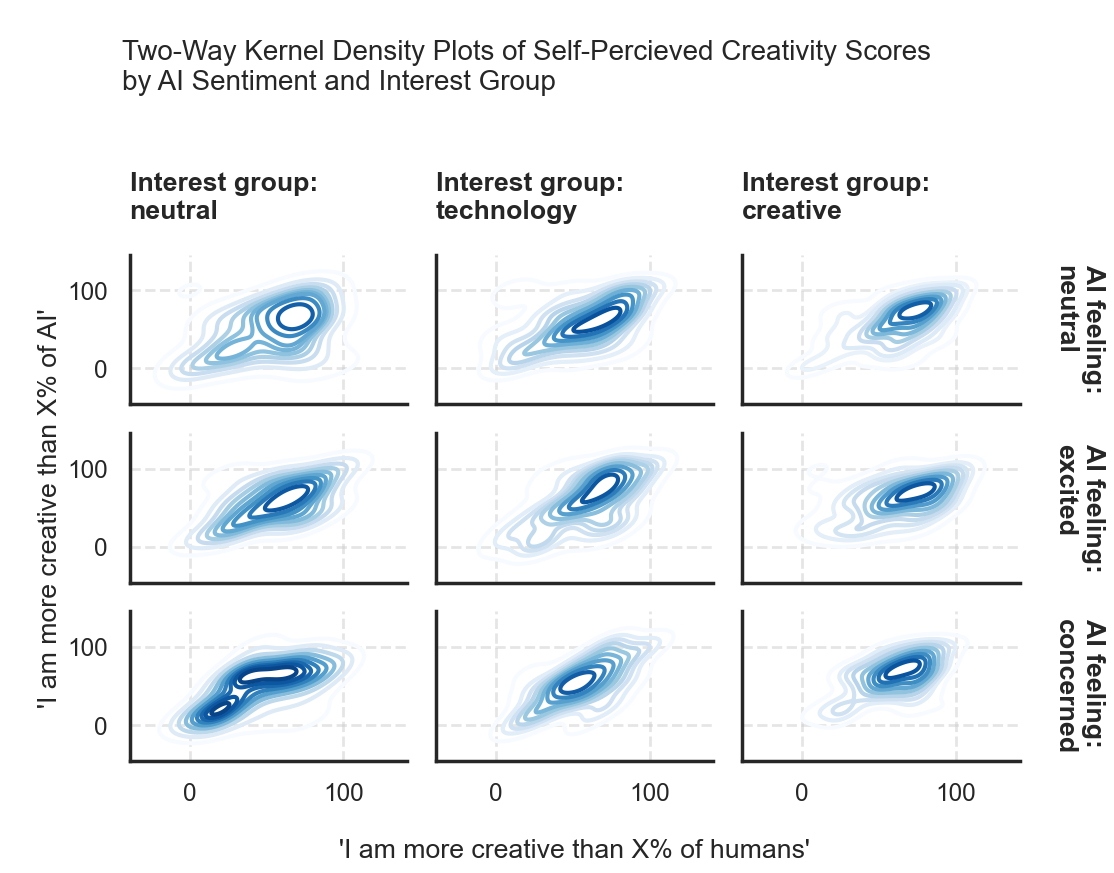

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def interest_group(source):
    creative_sources = ['Creative Mornings newsletter', 'r/writing', 'r/poetry']
    technology_sources = ['r/artificial', 'r/chatgpt', 'r/InternetIsBeautiful', 'r/singularity']
    neutral_sources = ['share', 'facebook', 'r/samplesize', 'other']
    
    if source in creative_sources:
        return "creative"
    elif source in technology_sources:
        return "technology"
    elif source in neutral_sources:
        return "neutral"
    else:
        print("ERROR YOU DIDNT ACCOUNT FOR SOME SOURCE")
        return "error"

def make_aesthetic(hex_color_list=None):
    """Make Seaborn look clean"""
    sns.set(style='white', context='poster', font_scale=0.8)
    if not hex_color_list:
        hex_color_list = [
        "#826AED", # Medium slate blue
        "#00A896", # Persian green
        "#D41876", # Telemagenta
        "#89DAFF", # Pale azure
        "#F7B2AD", # Melon
        "#342E37", # Dark grayish-purple
        "#7DCD85", # Emerald
        "#E87461", # Medium-bright orange
        "#E3B505", # Saffron
        "#2C3531", # Dark charcoal gray with a green undertone
        "#D4B2D8", # Pink lavender
        "#7E6551", # Coyote
        "#F45B69", # Vibrant pinkish-red
        "#020887", # Phthalo Blue
        "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    plt.rcParams['axes.titleweight'] = 'normal'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = False
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True
make_aesthetic()

df = pd.read_csv("../../data/experiment_data/data_clean.csv")
df['interest_group'] = df['source'].apply(lambda x: interest_group(x))
df = df.dropna(subset=['ai_feeling', 'interest_group', 'creativity_ai', 'creativity_human'])
df = df.drop_duplicates(subset=['participant_id'])


g = sns.FacetGrid(df, row="ai_feeling", col="interest_group", margin_titles=True, sharex=True, sharey=True, height=3, aspect=1.25)
g.map(sns.kdeplot, 'creativity_human', 'creativity_ai', cmap='Blues')

# Add some labels
g.set_axis_labels("I am more creative than\n X% of Humans", "Creativity AI")
g.set_titles(row_template="AI feeling:\n{row_name}\n", col_template="Interest group:\n{col_name}\n", fontweight='bold')
g.fig.suptitle('\nTwo-Way Kernel Density Plots of Self-Percieved Creativity Scores\nby AI Sentiment and Interest Group', size=20, ha='left', x=0.10)
g.fig.tight_layout(rect=[0, 0, 1, 0.96])

# Clearing default x and y labels
for ax in g.axes.flat:
    ax.set_xlabel('')
    ax.set_ylabel('')

g.axes[-1][1].set_xlabel("\n'I am more creative than X% of humans'")
g.axes[1][0].set_ylabel("\n'I am more creative than X% of AI'")

plt.savefig("two_way.png", dpi=400)

## Analysis 

Not included in the paper for length concerns

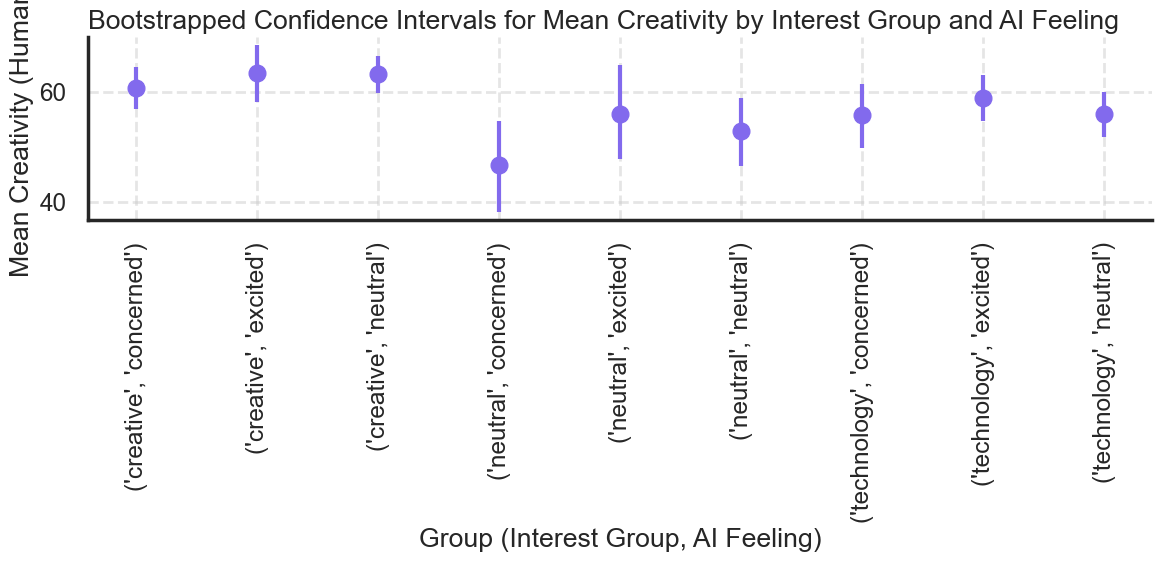

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def bootstrap_mean(data, n_bootstrap=1000, ci=95):
    boot_means = np.zeros(n_bootstrap)
    for i in range(n_bootstrap):
        resample = data.sample(n=len(data), replace=True)
        boot_means[i] = resample.mean()
    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, ci + (100 - ci) / 2)
    
    return lower, upper

# Filter out missing and duplicated values
df = df.dropna(subset=['creativity_human', 'interest_group', 'ai_feeling'])
df = df.drop_duplicates(subset=['participant_id'])

groups = []
means = []
lower_cis = []
upper_cis = []

# Bootstrap for each combination of interest_group and ai_feeling
for name, group in df.groupby(by=['interest_group', 'ai_feeling']):
    lower, upper = bootstrap_mean(group['creativity_human'])
    mean_val = group['creativity_human'].mean()
    
    groups.append(str(name))
    means.append(mean_val)
    lower_cis.append(lower)
    upper_cis.append(upper)

# Plot
plt.figure(figsize=(12, 6))

plt.errorbar(groups, means, yerr=[np.array(means) - np.array(lower_cis), np.array(upper_cis) - np.array(means)], fmt='o')
plt.xlabel('Group (Interest Group, AI Feeling)')
plt.ylabel('Mean Creativity (Human)')
plt.title('Bootstrapped Confidence Intervals for Mean Creativity by Interest Group and AI Feeling')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


# Other Checks 

## Were majority of people from English speaking countries?

In [29]:
#  Wank to know (1) what percentage of participants were from countries with high english speaking proficency and (2) average number of words of response
country_df = df['country'].value_counts(normalize=True).reset_index().head(5)
country_df.columns = ['country', 'percent_responses']
country_df['percent_responses'] = np.round(country_df['percent_responses']*100,2)
display(country_df)
sum_percent = country_df['percent_responses'].sum()
print(f"{sum_percent} percent of responses were from United States, Canada, Germany, UK, Australia")

,country,percent_responses
0,United States,53.62
1,Canada,7.83
2,Germany,5.94
3,United Kingdom,5.22
4,Australia,3.91


76.52 percent of responses were from United States, Canada, Germany, UK, Australia


## How long were responses? Is it likely English language proficency matters?

In [30]:
df['n_words'] = df['response_text'].apply(lambda x:len(x.split()))

mean_words = np.round(np.mean(df['n_words']),2)
med_words = np.round(np.median(df['n_words']),2)


print(f"The mean ({mean_words}) and median ({med_words}) response length were quite short.")

The mean (8.47) and median (6.0) response length were quite short.
